In [10]:
import re
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
MODEL_FILE = 'out/models/c-e298-l=0.23930-vl=0.25517.h5'
BOTTLENECKS_DIR = 'out/bottlenecks'
SAMPLE_SIZE = 515

PATIENTS_ENCODING = {
    '1': [1.,0.,0.],
    '2': [0.,1.,0.],
    '3': [0.,0.,1.]
}

In [39]:
test_files = pd.read_csv('sample_submission.csv').File.values
model = keras.models.load_model(MODEL_FILE)

In [40]:
def process_batch(files, samples, model, res_df=None):
    
    samples = np.array(samples, dtype=np.float32).reshape((-1, SAMPLE_SIZE))
    y_p = model.predict(samples, verbose=False, batch_size=32)
    batch_df = pd.DataFrame({'File': files, 'Class': y_p.T[0]})

    if res_df is None:
        return batch_df
    else:
        return res_df.append(batch_df)

In [41]:
BATCH_SIZE = 500
batch_files = []
batch_samples = []
res_df = None

for f in tqdm(test_files):
    
    fid = re.findall(r'(.+)\.mat$', f)[0]
    batch_files.append(f)
    
    bn_f = BOTTLENECKS_DIR + '/' + fid + '.npy'
    bn = np.load(bn_f)
    
    patient = fid[0]
    patient = PATIENTS_ENCODING[patient]
    
    sample = np.concatenate((patient, bn.flatten())).astype(np.float32)

    batch_samples.append(sample)
    
    if len(batch_files) == BATCH_SIZE:
        res_df = process_batch(batch_files, batch_samples, model, res_df)
        batch_files = []
        batch_samples = []

if len(batch_files):
    res_df = process_batch(batch_files, batch_samples, model, res_df)

100%|██████████| 6126/6126 [00:01<00:00, 5047.02it/s]


In [42]:
res_df.to_csv('subm-f.csv', index=False, columns=['File', 'Class'], float_format='%.8f')

(array([ 2513.,  3613.]),
 array([  9.11439747e-06,   6.90888141e-02,   1.38168514e-01]),
 <a list of 2 Patch objects>)

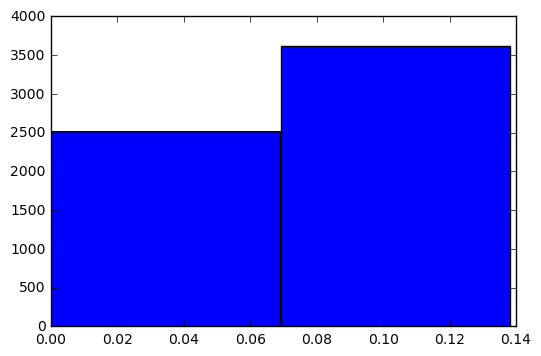

In [43]:
plt.hist(res_df.Class.values, bins=2)

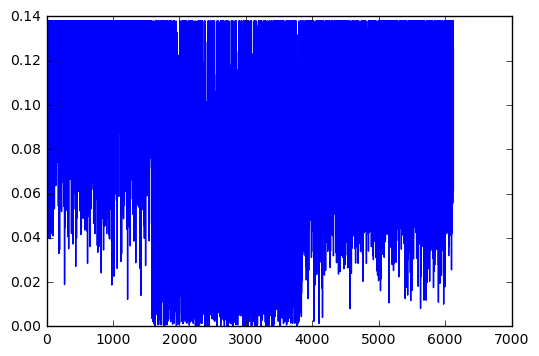

In [44]:
plt.plot(res_df.Class.values)